In [1]:
import keras
from keras.datasets import mnist
from matplotlib import pyplot as plt
import cv2
import numpy as np
import scipy.ndimage
import random
import math

Using TensorFlow backend.


## Store and display Mnist 0-9 digits  in a dictionary :

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def store_0_9_digits():
    digits = {}
    for i in range (len(y_train)):
        if y_train[i] in digits:
            # append the new number to the existing array at this slot
            digits[y_train[i]].append(x_train[i])
        else:
            # create a new array in this slot
            digits[y_train[i]] = [x_train[i]]
    return digits
     
    
def display_0_9_digits(digits):
    cols = 3
    rows = 4
    plt.figure(figsize=[20,10])
    keys_list = [*digits]
    keys_list.sort()
    for i in range(len(digits)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(digits[i][0], cmap='gray')
        plt.title(keys_list[i])
    plt.tight_layout()


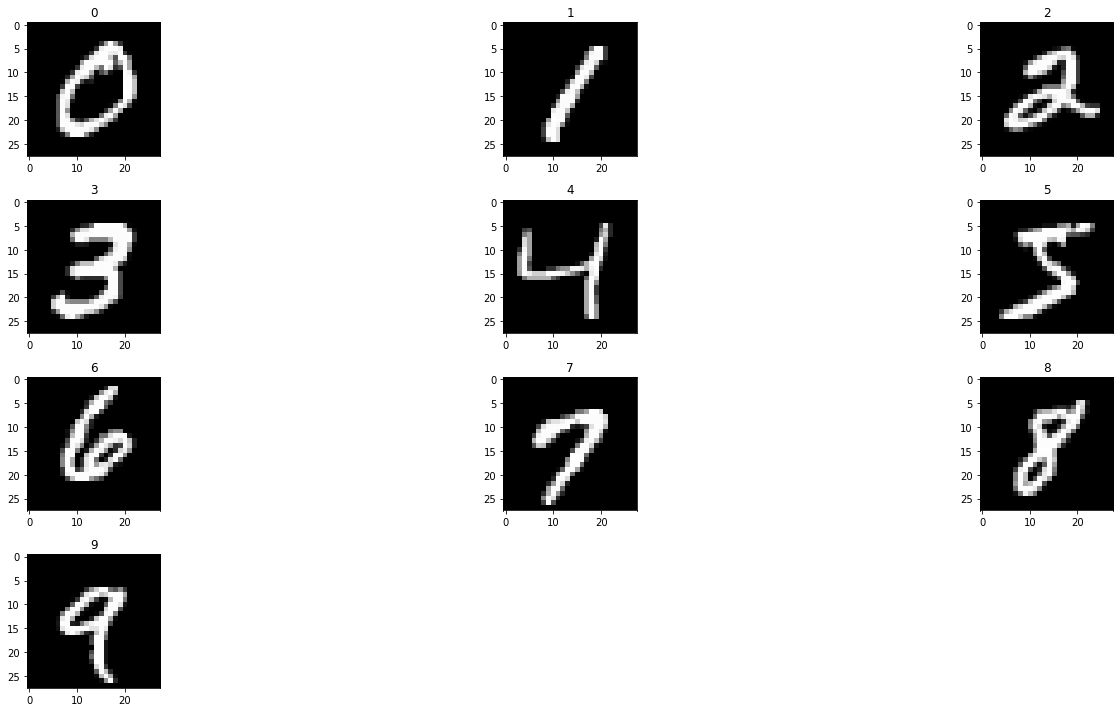

In [3]:
digits = store_0_9_digits()
display_0_9_digits(digits)

## Use digits dictionary to generate a 3 digits number, store it inside -> numbers dictionary.
 

In [ ]:
def images_from_0_to_x(digits, limit, number_examples):
    numbers={}
    for number in range(limit):
        hundreds = number//100
        tens = (number//10)%10
        singles_digit = number%10
        for j in range(number_examples):  #number_examples = Set how many samples from every number
            
            #Generate image from storage:
            random_from_hundreds = random.randint(0, len(digits[hundreds]) - 1)
            random_from_tens = random.randint(0, len(digits[tens]) - 1 )
            random_from_singles = random.randint(0, len(digits[singles_digit]) - 1)
            
            #Create new image by concatenating
            three_digit_presentation = np.concatenate((digits[hundreds][random_from_hundreds],
            (digits[tens][random_from_tens]),
            (digits[singles_digit][random_from_singles])), axis = 1)
            if number in numbers:                
                # append the new number to the existing array at this slot
                numbers[number].append(three_digit_presentation)
            else:
                # create a new array in this slot
                numbers[number] = [three_digit_presentation]
    return numbers



def display_random_images(num_of_images, numbers):
    cols = 3
    rows = num_of_images//cols + 1
    plt.figure(figsize=[20,10])
    keys_list = [*numbers]
    keys_list.sort()
    for i in range(num_of_images):
        random_number = random.randint(0, 100)
        plt.subplot(rows, cols, i+1)
        plt.imshow(numbers[random_number][0], cmap='gray')
        plt.title(keys_list[random_number])
    plt.tight_layout()



In [5]:
limit = 100
number_examples = 6000
numbers = images_from_0_to_x(digits, limit, number_examples)


## Display some random images

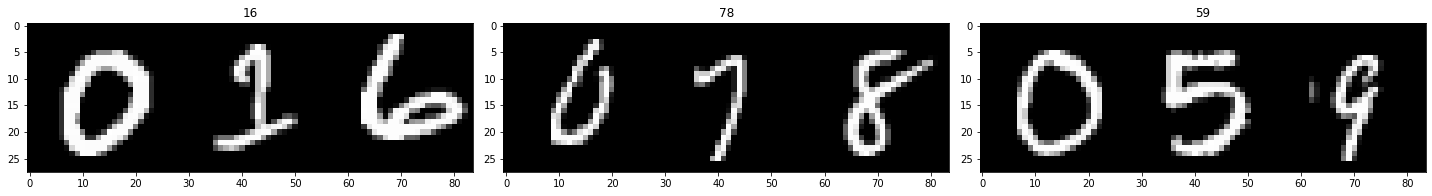

In [6]:
num_of_images_display = 3
display_random_images(num_of_images_display, numbers)

## Some augmentations over the images

In [7]:
class Manipulate(object):
    def flip(self, img):
        return cv2.flip(img, 1)
    
    
    def rotate(self, pic, angle):
        centerH,centerW = pic.shape[0]//2,pic.shape[1]//2
        rotation_matrix = cv2.getRotationMatrix2D((centerW, centerH), angle, 1)
        return abs(cv2.warpAffine(pic, rotation_matrix, (pic.shape[1],pic.shape[0])))
    
    def GaussianBlur(self, image, kernel_size):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size),0)
    
    def medianBlur(self, image, kernel_size):
        image = image.astype(np.uint8)
        return cv2.medianBlur(image, kernel_size)
    
    def zoom(self, image, zoom_factor):
        height, width = image.shape[0:2]
        new_width = (np.array((zoom_factor*width)/2)).astype(int)
        new_height = (np.array((zoom_factor*height)/2)).astype(int)
        cropped = self.crop(image, new_height,-new_height, new_width, -new_width)
        return cv2.resize(cropped, (width, height))
    
    def crop(self, image, fromRow, toRow, fromCol, toCol):
        return image[fromRow:toRow, fromCol:toCol]
    
    
    def vertical_sobel(self, image):
        return cv2.Sobel(image, cv2.CV_32F, 1, 0)
    
    
    def horizontal_sobel(self, image):
        return cv2.Sobel(image, cv2.CV_32F, 0, 1)
    
    
    def sharpen_filter(self, image):
        kernel = np.array([[-1,-1,-1,-1,-1],
                        [-1,2,2,2,-1],
                        [-1,2,8,2,-1],
                        [-1,2,2,2,-1],
                        [-1,-1,-1,-1,-1]]) / 8.0
        return cv2.filter2D(image, -1, kernel)

    
    def boxFilter(self, image):
        return cv2.boxFilter(image, -1, (15,15))
    
    
    def dilate(self, image):
        kernel = np.ones((3,3), np.uint8)
        return cv2.dilate(image, kernel)
    
    
    def erode(self, image):
        kernel = np.ones((3,3), np.uint8)
        return cv2.erode(image, kernel)
    
    
    def morph_gradient(self, image):
        kernel = np.ones((3,3), np.uint8)
        return cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
        
    
    def colorMap(self, image):
        image = image.astype(np.uint8)
        return cv2.applyColorMap(image, cv2.COLORMAP_HSV)
    
    
    def laplacian(self, image):
        image = image.astype(np.uint8)
        return cv2.Laplacian(image, cv2.CV_8U)
        
        
    
    def find_contours(self, image):
        image = image.astype(np.uint8)
        edges = cv2.Canny(image, 50,100)
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        return cv2.drawContours(image.copy(), contours, -1, (0, 255, 255), 1)



# The augmentations that will not use is:
<ul>
  <li>Crop</li>
  <li>Zoom</li>
  <li>Rotate</li>
  <li>Flip</li>
 </ul>
    
**All these can affect on the number that we will get eventually and not recommended to use**

In [8]:
class GenerateManipulation(Manipulate):
    
    def __init__(self, image, N, M, number):
        self.image = image
        self.N = N
        self.M = M
        self.number = number
        self.methods = [ m for m in dir(Manipulate) if not m.startswith('__')]
        
        
    def select_n_augmentations(self, image):
        selected = np.random.choice(self.methods, self.N, replace=True, p=self.M)
        for i in range(self.N):
            manipulated = self.call_function(selected[i])
            self.image = manipulated              
        return manipulated, selected

    def call_function(self, method):
        cords_for_crop = self.gen_numbers(self.image)
        functions = {
            'flip': self.flip(self.image),
            'rotate': self.rotate(self.image, random.randint(1,360)),
            'GaussianBlur': self.GaussianBlur(self.image, 7),
            'medianBlur':self.medianBlur(self.image, 7),
            'zoom': self.zoom(self.image, (random.randint(1, 9))/10),
            'crop': self.crop(self.image, cords_for_crop[0], cords_for_crop[1], cords_for_crop[2], cords_for_crop[3]),
            'vertical_sobel': self.vertical_sobel(self.image),
            'horizontal_sobel': self.horizontal_sobel(self.image),
            'sharpen_filter': self.sharpen_filter(self.image),
            'boxFilter': self.boxFilter(self.image),
            'dilate': self.dilate(self.image),
            'erode': self.erode(self.image),
            'morph_gradient': self.morph_gradient(self.image),
            'colorMap': self.colorMap(self.image),
            'laplacian': self.laplacian(self.image),
            'find_contours': self.find_contours(self.image)
        }
        return functions.get(method)
        
        
    def gen_numbers(self, image):
        fromRow = random.randint(1,self.image.shape[0] - 2)
        toRow = random.randint(fromRow, self.image.shape[0] -1)
        fromCol = random.randint(1,self.image.shape[1] - 2)
        toCol = random.randint(fromCol, self.image.shape[1] -1)
        return (fromRow, toRow, fromCol, toCol)
    
        
              
        
    def display_images2(self, image, functions):
        fig = plt.figure(figsize=[5,4])
        for i in range(self.N):
            upper = ", "
            upper = upper.join(functions)
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(image, cmap = 'gray')
        down = str(self.number)
        title = upper + "\n" + down
        ax.set_title(title, y=1.01)
        plt.tight_layout()

In [9]:
list_of_augmentations = [ m for m in dir(Manipulate) if not m.startswith('__')]
damage_augs = ['crop', 'flip', 'rotate', 'zoom']
print(list_of_augmentations)

['GaussianBlur', 'boxFilter', 'colorMap', 'crop', 'dilate', 'erode', 'find_contours', 'flip', 'horizontal_sobel', 'laplacian', 'medianBlur', 'morph_gradient', 'rotate', 'sharpen_filter', 'vertical_sobel', 'zoom']


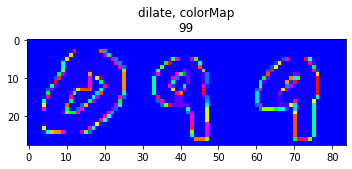

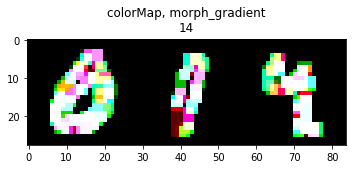

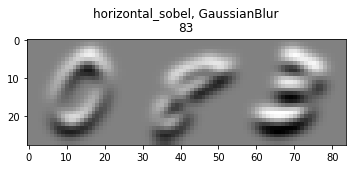

In [20]:
def rand_0_1():
    return random.uniform(0, 1)


number_of_times = 3
for i in range (number_of_times):
    random_number = random.randint(0, 99)
    image_to_manipulate = numbers[random_number][0]
    
    #generate probabilities for the augmentations without problem to use and give zeros to those who wont use.
    probabilities = []
    for f_name in list_of_augmentations:
        if f_name in damage_augs:
            probabilities.append(0)
        else:
            probabilities.append(rand_0_1())
    
    prob_normalization = [value/sum(probabilities) for value in probabilities]
    gm2 = GenerateManipulation(image_to_manipulate, 2, prob_normalization, random_number)
    manipulated_images, titles = gm2.select_n_augmentations(image_to_manipulate)
    gm2.display_images2(manipulated_images, titles)


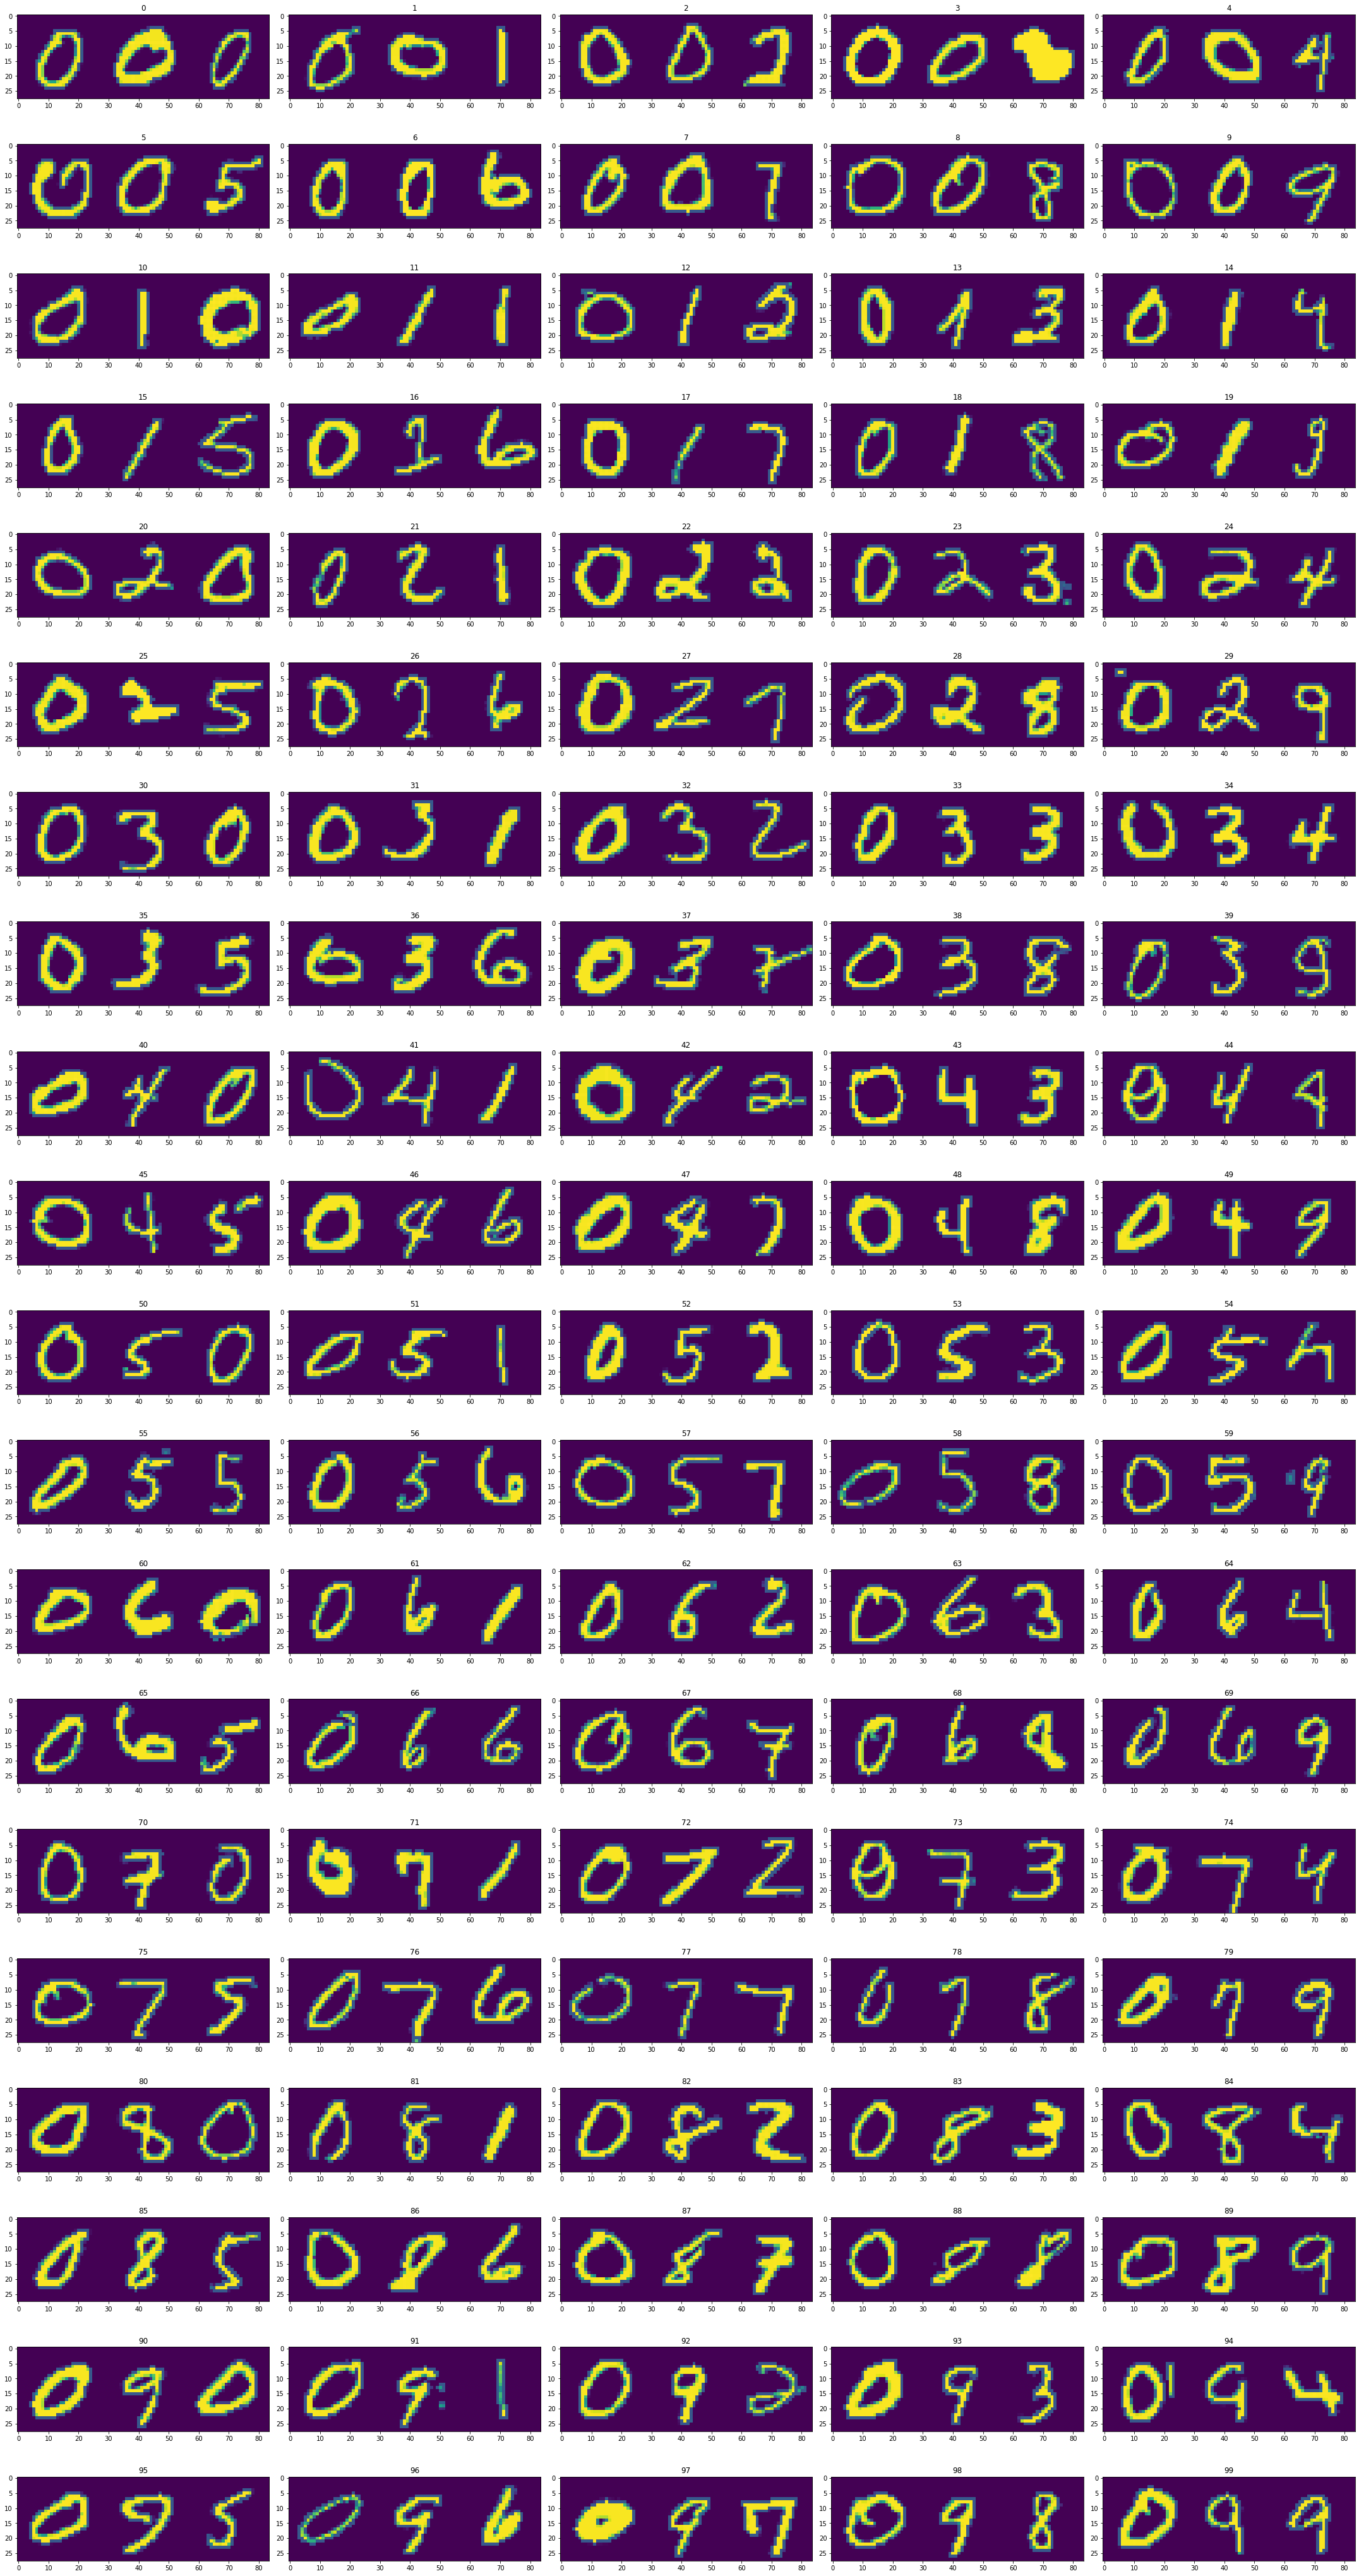

In [28]:
def draw_contours(numbers):
    plt.figure(figsize=[30,60])
    cols = 5
    rows = len(numbers)//cols + 1
    for i in range(len(numbers)):
        number_edges = cv2.Canny(numbers[i][0], 50,150)
        number_cpy = numbers[i][0].copy()
        contours, hierarchy = cv2.findContours(number_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(number_cpy, contours, -1, (70, 50, 255), 1)
       
        
        keys_list = [*numbers]
        keys_list.sort()
        plt.subplot(rows, cols, i+1)
        plt.imshow(number_cpy)
        plt.title(keys_list[i])
    plt.tight_layout()
        

draw_contours(numbers)